# Local Search Algorithm in Qamomile
In this section, we will solve the TSP problem using Local Search Algorithm with the help of the `JijModeling` and `Qamomile` libraries , and we will compare the results with the SA sampler in `OpenJij`.

First, let's install and import the main libraries we will be using.

In [1]:
import jijmodeling as jm
import openjij as oj
import jijmodeling_transpiler as jmt
import numpy as np
import matplotlib.pyplot as plt

## What is Local Search Algorithm?

The Local Search Algorithm (LS) is one of the simplest heuristic algorithms for optimization problems. Assume the input model has the form of an Ising Hamiltonian:

$$
E(\vec{s}) = \sum_{ij} J_{ij} s_i s_j + \sum_i h_i s_i + E_0, \quad s_i \in \{-1, 1\}
$$

where $E_0$ is a constant term. We aim to find the state $\vec{s}$ that minimizes the energy. The core idea of the LS algorithm is to move to a new state that decreases the energy.

Suppose we have the current state $\vec{s}_{t}$. If we find a state $\vec{s}_{t+1}$ such that $E(\vec{s}_{t+1}) < E(\vec{s}_{t})$, we update the current state to $\vec{s}_{t+1}$. This process is repeated until no new state can be found that further minimizes the current energy.

There are several methods to generate a new state $\vec{s}_{t+1}$. The simplest method is the **single spin flip**, where the spin variable $s_i$ is flipped to $-s_i$. This approach changes only one variable in the state, hence the term "single spin flip." The number

Furthermore, there are two choices how to choose variable to flip, **First Improvement** and **Best Improvement**. 

### First Improvement
Check $\Delta E_i$ in either index order or randomly. If you find a variable $s_i$ such that $\Delta E_i < 0$, flip $s_i$.

### Best Improvement
Check $\Delta E_i$ for all variables $s_i$. Then, flip the $s_i$ that results in the largest decrease in $\Delta E_i$.

## Formulation using JijModeling
Now that everything is ready, let's first model the problem using JijModeling.

In [2]:
d = jm.Placeholder("d", ndim=2)
n = d.len_at(0, latex="n")

i, j, t = jm.Element("i", n), jm.Element("j", n), jm.Element("t", n)

x = jm.BinaryVar("x", shape=(n, n))

problem = jm.Problem("TSP")
# Objective function
problem += jm.sum([i, j], d[i, j]*jm.sum(t, x[i, t]*x[j, (t+1) % n]))

# Constraints
jmC = jm.Constraint
problem += jmC("one-time", x[i, :].sum() == 1, forall=i)
problem += jmC("one-city", x[:, t].sum() == 1, forall=t)

problem

## Preparing the problem
We will now prepare the problem to be solved. Here, we will create it using a random graph

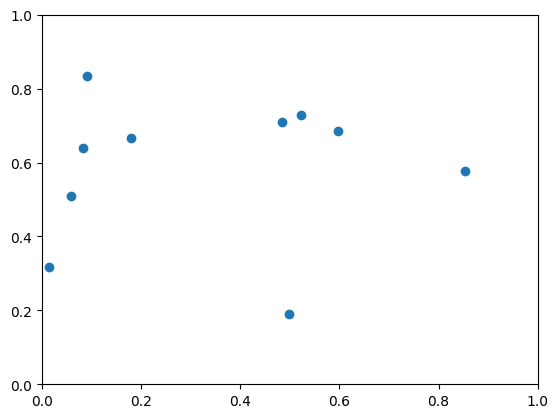

In [3]:
def random_2d_tsp(n: int):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    XX, YY = np.meshgrid(x, y)
    distance = np.sqrt((XX - XX.T)**2 + (YY - YY.T)**2)
    return distance, (x, y)

num_city = 10
distance, (pos_x, pos_y) = random_2d_tsp(n=num_city)

plt.scatter(pos_x, pos_y)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

We will prepare the problem data in a format that can be used with the model created in JijModeling

## Creating a Compiled Instance

A compiled instance is an intermediate representation where actual values are substituted into the constants of the mathematical expressions. Before converting to various algorithms, it is necessary to first create this compiled instance.

In [4]:
compiled_instance = jmt.core.compile_model(problem, {"d": distance})

## SA Sampler

We can first obtain the solution from the [SA sampler](https://www.documentation.jijzept.com/docs/jijmodelingtranspiler/tutorials/tsp_qubo_transpiler) in `OpenJij`.

In [5]:
# Transpile to QUBO
qubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_instance)
multipliers = {"one-time": 1.0, "one-city": 1.0}
qubo, offset = qubo_builder.get_qubo_dict(multipliers=multipliers)
sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)

In [6]:
decoded = jmt.core.pubo.decode_from_openjij(response, qubo_builder, compiled_instance)
feasibles = decoded.feasible()
objectives = np.array(feasibles.evaluation.objective)
lowest_index = np.argmin(objectives)
print(f"Lowest solution index: {lowest_index}, Lowest objective value: {objectives[lowest_index]}")

Lowest solution index: 0, Lowest objective value: 2.691522030772346


In [7]:
# check solution
nonzero_indices, nonzero_values, shape = feasibles.record.solution["x"][lowest_index]
print("indices: ", nonzero_indices)
print("values: ", nonzero_values)

indices:  ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [8, 3, 2, 5, 9, 4, 6, 7, 1, 0])
values:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Local Search Algorithm
Now, we solve the same problem using a Local Search Algorithm

In [8]:
from qamomile.core.post_process.local_search import *
from qamomile.core.converters.converter import QuantumConverter
from qamomile.core.transpiler import QuantumSDKTranspiler as transpiler

ising= IsingConverter(compiled_instance)
#ising=qubo_to_ising(qubo_builder.objective.coeff ,qubo_builder.objective.constant)

Create the initial state

In [24]:
size = max(max(i, j) for i, j in ising.ising_encode().quad.keys()) + 1
initial_state = np.random.choice([-1, 1], size=size)

In [10]:
result=run(first_improvement,ising.ising_encode(), initial_state)

Decode the final state to a SampleSet

In [11]:
from qamomile.core.bitssample import BitsSample, BitsSampleSet
sample = BitsSample(1,np.where(result == -1, 0, 1).tolist())
sample_set = BitsSampleSet(bitarrays=[sample])
decoded_sampleset=ising.decode_bits_to_sampleset(sample_set)
print(decoded_sampleset) #data[0].var_values['x'].values

SampleSet(data=[Sample(run_id="9c1fb53f-deb8-4db6-a653-70e751c67e58", num_occurrences=1, run_info={}, var_values={"x": SparseVarValues(name="x", values={(0, 4): 1, (1, 6): 1, (2, 3): 1, (3, 7): 1, (4, 9): 1, (5, 1): 1, (6, 2): 1, (7, 5): 1, (8, 0): 1, (9, 8): 1}, shape=(10, 10), var_type=VarType.CONTINUOUS)}, eval=EvaluationResult(objective=4.333447879322408, constraints={"one-city": Violation(name="one-city", total_violation=0, ... ), "one-time": Violation(name="one-time", total_violation=0, ... )}, penalties={}))], set_id="12679d6c-b0a2-441d-992b-d797a2b93fee", set_info={}, run_info={}, measuring_time=MeasuringTime(solving_time=SolvingTime(compiling_time=0, transpiling_time=0, preprocess_time=0, solving_time=0, decoding_time=0, postprocess_time=0), system_time=SystemTime(posting_time=None, request_queuing_time=None, fetching_problem_time=None, fetching_result_time=None, deserialize_time=None)), run_times={})


## Compare the result


In [12]:
def convert_to_tour(nonzero_indices, num_city):
    tour = np.zeros(num_city, dtype=int)
    i_value, t_value = nonzero_indices
    tour[t_value] = i_value
    tour = np.append(tour, [tour[0]])
    return tour

tour = convert_to_tour(nonzero_indices, num_city)
print(f"Tour is {tour} from SA sampler")

Tour is [9 8 2 1 5 3 6 7 0 4 9] from SA sampler


In [13]:
cities = sorted({k[0] for k in decoded_sampleset.data[0].var_values['x'].values.keys()}.union({k[1] for k in decoded_sampleset.data[0].var_values['x'].values.keys()}))

time = [-1] * len(cities)

# Fill in the mappings
for (src, dest), value in decoded_sampleset.data[0].var_values['x'].values.items():
    time[src] = dest

print("Cities:", cities)
print("Time order:", time)
tour2 = convert_to_tour((cities,time), num_city)
print(f"Tour is {tour2} from Local Search")

Cities: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Time order: [4, 6, 3, 7, 9, 1, 2, 5, 0, 8]
Tour is [8 5 6 2 0 7 1 3 9 4 8] from Local Search


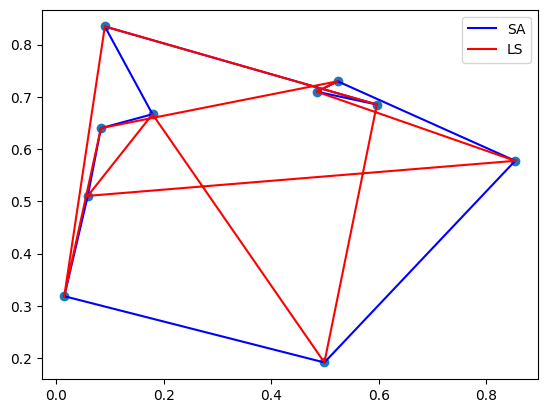

In [14]:
plt.scatter(pos_x, pos_y)
plt.plot(pos_x[tour], pos_y[tour], "-", color="blue", label="SA")
plt.plot(pos_x[tour2], pos_y[tour2], "-", color="red", label="LS")

plt.legend()
plt.show()

Let's see the difference in terms of energy

In [21]:
#calc_qubo_energy(qubo_builder.objective.coeff, response.record['sample'][0].tolist())
#calc_qubo_energy(qubo_builder.objective.coeff, np.where(sampleset == -1, 0, 1).tolist())
print(f"energy calculated by LS is {ising.ising_encode().calc_energy(result.tolist())}")

energy calculated by LS is 1607.4544206846372


In [23]:
qubo_list = response.record['sample'][0]
spin_list = [2 * b - 1 for b in qubo_list]
print(f"energy calculated by SA is {ising.ising_encode().calc_energy(spin_list)}")

energy calculated by SA is 1605.8124948360878
